# Lab 6: Variable Selection and Regularization

In [59]:
# Dependencies
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

from plotnine import *
from sklearn.model_selection import GridSearchCV
from numpy import arange

In [60]:
hitters = pd.read_csv("Hitters.csv")

In [61]:
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [62]:
#deciding to drop na values as there was only 59
hitters = hitters.dropna()

# Part I: Different Model Specs

## A. Regression without regularization
---

### 1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression

In [63]:
# Setting up the X and Y, predicting Salary with all other variables
X = hitters.drop(["Salary"], axis = 1) #note these were dropped, as order is an idex and pID is key id
y = hitters["Salary"]

#Preprocessor as a column transformer that dumifies, standardizes.
ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'), # what does the handle_unkow = 'ignore' do? sparse, array, handle, ignores unknown cats to 0
    make_column_selector(dtype_include=object)), #note the make_column_selector(dtype_include=object) will return all columns that are string objects.
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number)) #this one returns all columns that have numbers
  ],
  remainder = "passthrough" # we are doing this because we are keeping all the other variables
)

#putting the preprocessor and model spec in the pipeline creation
lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

### 2. Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

In [64]:
ols_model_full = lr_pipeline_1.fit(X,y)
ols_coef_full = ols_model_full.named_steps["linear_regression"].coef_
ols_coef_full

array([ -31.29971152,   31.29971152,   58.42462282,  -58.42462282,
         12.38116255,  -12.38116255, -291.0945557 ,  337.83047948,
         37.85383676,  -60.57247861,  -26.99498379,  135.07389695,
        -16.69335888, -391.03865466,   86.68761664,  -14.18172332,
        480.74713477,  260.68988581, -213.89225864,   78.76129639,
         53.73248973,  -22.16086217])

In [65]:
# GETTING THE FEATURES OUT
ols_features = ct.get_feature_names_out()

features_coeff = pd.DataFrame({'OLS_Feature': ols_features, 'OLS_Coefficient': ols_coef_full})
# Add a new column 'Absolute_Coefficient' to features_coeff
features_coeff['Absolute_Coefficient'] = features_coeff['OLS_Coefficient'].abs()
features_coeff.sort_values(by='Absolute_Coefficient', ascending=False)[0:5]

,OLS_Feature,OLS_Coefficient,Absolute_Coefficient
16,standardize__CRuns,480.747135,480.747135
13,standardize__CAtBat,-391.038655,391.038655
7,standardize__Hits,337.830479,337.830479
6,standardize__AtBat,-291.094556,291.094556
17,standardize__CRBI,260.689886,260.689886


- The number of runs has the greatest effect on Salary here with one standard deviation unit increase in runs having a 480 standard deviation increase to the salary.
- Notably as well, for a one unit standard deviation increase in the number of times at bat in career salary can be expected to decrease by 391 standard deviations.
- One unit increase standard deviation in the number of hits here has a positive effect on Salary of 337 standard deviations.

### 3. Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [66]:
ols_MSE_scores = cross_val_score(lr_pipeline_1, X, y, cv=5, scoring='neg_mean_squared_error')

# Calculate the positive mean of the negative MSE scores
ols_mean_MSE = -np.mean(ols_MSE_scores)

ols_mean_MSE

121136.31031816886

## B. Ridge regression

### 1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

In [67]:
#Model Specification
ridge = Ridge()

#putting the preprocessor and model spec in the pipeline
ridge_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", ridge)]
)

### 2. Use cross-validation to tune the lambda hyperparameter.

In [68]:
#tuning using grid Search
alpha = {'ridge_regression__alpha': [.0001, .001, .01, .1, 1, 10]}

gscv = GridSearchCV(ridge_pipeline_1, alpha, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

mean_test_scores = gscv_fitted.cv_results_['mean_test_score']
alphas = gscv_fitted.cv_results_['param_ridge_regression__alpha']

# Creating a DataFrame with degrees and scores
ridge_model_scores = pd.DataFrame(data = {"lambdas": alphas, "scores": -(mean_test_scores)}).sort_values(by='scores', ascending=True)
ridge_model_scores

,lambdas,scores
4,1,119144.432677
5,10,119348.984776
3,0.1,120343.621067
2,0.01,121022.903286
1,0.001,121124.458592
0,0.0001,121135.119780


### 3. Fit the pipeline with your chosen lambda to the full dataset, and interpret a few of the most important coefficients.

In [69]:
#Model Specification
ridge = Ridge(alpha = 1)

#putting the preprocessor and model spec in the pipeline
ridge_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", ridge)]
)

In [70]:
ridge_model = ridge_pipeline_1.fit(X,y)
ridge_model_coef = ridge_model.named_steps['ridge_regression'].coef_
ridge_model_coef

array([ -30.43885531,   30.43885531,   60.01559493,  -60.01559493,
         13.11128155,  -13.11128155, -270.6864407 ,  296.64505003,
         18.10059158,  -29.33940613,   -9.11329453,  124.40717273,
        -38.66774782, -225.40654798,  126.65960655,   39.07092364,
        320.41216891,  160.38678418, -184.4236106 ,   78.62365619,
         47.46259711,  -23.72419031])

In [71]:
# GETTING THE FEATURES OUT
ridge_features = ct.get_feature_names_out()

features_coeff = pd.DataFrame({'ridge_Feature': ols_features, 'ridge_Coefficient': ridge_model_coef})
# Add a new column 'Absolute_Coefficient' to features_coeff
features_coeff['Absolute_Coefficient'] = features_coeff['ridge_Coefficient'].abs()
features_coeff.sort_values(by='Absolute_Coefficient', ascending=False)[0:5]

,ridge_Feature,ridge_Coefficient,Absolute_Coefficient
16,standardize__CRuns,320.412169,320.412169
7,standardize__Hits,296.645050,296.645050
6,standardize__AtBat,-270.686441,270.686441
13,standardize__CAtBat,-225.406548,225.406548
18,standardize__CWalks,-184.423611,184.423611


- The number of runs in their overall career has the greatest effect on Salary here with one unit standard deviation increase in runs having a 320 standard deviation increase to the salary.
- One unit standard deviation increase in the number of hits here has a positive effect on Salary of 297 in terms of standard deviations.
- Notably as well, for a one unit increase standard deviation in the number of times at bat for the season salary can be expected to decrease by 270 standard deviations.

### 4.Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

Per the tuning, we can reasonably expect this model to have an MSE of 119144.432677 when used to predict 1989 salaries.

## C. Lasso Regression
---

### 1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary Lasso regression

In [72]:
#Model Specification
lasso = Lasso()

#putting the preprocessor and model spec in the pipeline
lasso_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", lasso)]
)

### 2. Use cross-validation to tune the lambda hyperparameter.

In [73]:
#tuning using grid Search
alpha = {'lasso_regression__alpha': [.0001, .001, .01, .1, 1, 10]}

gscv = GridSearchCV(lasso_pipeline_1, alpha, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

mean_test_scores = gscv_fitted.cv_results_['mean_test_score']
alphas = gscv_fitted.cv_results_['param_lasso_regression__alpha']

# Creating a DataFrame with degrees and scores
lasso_model_scores = pd.DataFrame(data = {"lambda": alphas, "scores": -(mean_test_scores)}).sort_values(by='scores', ascending=True)
lasso_model_scores

C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.035e+07, tolerance: 4.708e+03
C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.155e+06, tolerance: 3.606e+03
C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.026e+07, tolerance: 4.137e+03
C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordina

,lambda,scores
4,1,119761.587407
3,0.1,120682.252637
2,0.01,120964.764686
1,0.001,120994.179815
0,0.0001,120997.134215
5,10,121828.141333


### 3. Fit the pipeline with your chosen lambda to the full dataset, and interpret a few of the most important coefficients.


In [74]:
#Model Specification
lasso = Lasso(alpha = 1)

#putting the preprocessor and model spec in the pipeline
lasso_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", lasso)]
)

In [75]:
lasso_model = lasso_pipeline_1.fit(X,y)
lasso_model_coef = lasso_model.named_steps['lasso_regression'].coef_
lasso_model_coef

array([-3.58260721e+01,  0.00000000e+00,  1.14412951e+02, -2.13116651e-11,
        0.00000000e+00, -0.00000000e+00, -2.82370957e+02,  3.04359509e+02,
        1.11270220e+01, -2.49665071e+01, -0.00000000e+00,  1.20695275e+02,
       -3.49481481e+01, -1.62639794e+02,  0.00000000e+00,  1.42259932e+01,
        3.75565519e+02,  1.92610892e+02, -1.89644642e+02,  7.87603658e+01,
        4.19966795e+01, -1.84793784e+01])

In [76]:
# GETTING THE FEATURES OUT
lasso_features = ct.get_feature_names_out()

features_coeff = pd.DataFrame({'lasso_Feature': ols_features, 'lasso_Coefficient': lasso_model_coef})
# Add a new column 'Absolute_Coefficient' to features_coeff
features_coeff['Absolute_Coefficient'] = features_coeff['lasso_Coefficient'].abs()
features_coeff.sort_values(by='Absolute_Coefficient', ascending=False)[0:5]

,lasso_Feature,lasso_Coefficient,Absolute_Coefficient
16,standardize__CRuns,375.565519,375.565519
7,standardize__Hits,304.359509,304.359509
6,standardize__AtBat,-282.370957,282.370957
17,standardize__CRBI,192.610892,192.610892
18,standardize__CWalks,-189.644642,189.644642


- The number of runs in their overall career has the greatest effect on Salary here with one unit increase in standard deviation in runs having a 376 standard deviation increase to the salary.
- One unit increase in standard deviations to the number of hits per season here has a positive effect on Salary of 304 in standard deviations.
- Notably as well, for a one unit increase in standard deviations in the number of times at bat for the season salary can be expected to decrease by 282 in salary standard deviations.

### 4.Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

Per the tuning, we can reasonably expect this model to have an MSE of 119761.587407 when used to predict 1989 salaries.

## D. Elastic Net
---

### 1. Create a pipeline that includes all the columns as predictors for Salary, and performs Elastic Net regression

In [77]:
#Model Specification
enet = ElasticNet()

#putting the preprocessor and model spec in the pipeline
enet_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("enet_regression", enet)]
)

### 2. Use cross-validation to tune the lambda hyperparameter.

In [78]:
#tuning using grid Search
params = {'enet_regression__alpha': [.0001, .001, .01, .1, 1, 10],
          'enet_regression__l1_ratio': [.1, .2, .4, .6, .8, .9]}

gscv = GridSearchCV(enet_pipeline_1, params, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

mean_test_scores = gscv_fitted.cv_results_['mean_test_score']
alphas = gscv_fitted.cv_results_['param_enet_regression__alpha']
ratios = gscv_fitted.cv_results_['param_enet_regression__l1_ratio']

# Creating a DataFrame with degrees and scores
enet_model_scores = pd.DataFrame(data = {"lambda": alphas, "alpha": ratios, "scores": -(mean_test_scores)}).sort_values(by='scores', ascending=True)
enet_model_scores.head()

C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.039e+07, tolerance: 4.708e+03
C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.177e+06, tolerance: 3.606e+03
C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.029e+07, tolerance: 4.137e+03
C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordina

C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.657e+06, tolerance: 4.558e+03
C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.015e+07, tolerance: 4.708e+03
C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.010e+06, tolerance: 3.606e+03
C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordina

C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.683e+05, tolerance: 4.558e+03


,lambda,alpha,scores
23,0.1,0.9,118969.493401
12,0.01,0.1,118973.789477
22,0.1,0.8,118994.427874
13,0.01,0.2,118995.938080
14,0.01,0.4,119067.258302


### 3. Fit the pipeline with your chosen lambda and alpha to the full dataset, and interpret a few of the most important coefficients.


In [79]:
#Model Specification
enet = ElasticNet(alpha = .1, l1_ratio = .9)

#putting the preprocessor and model spec in the pipeline
enet_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("enet_regression", enet)]
)

In [81]:
enet_model = enet_pipeline_1.fit(X,y)
enet_model_coef = enet_model.named_steps['enet_regression'].coef_

In [82]:
enet_model_coef

array([ -27.87968482,   27.87998427,   60.67059233,  -60.67174945,
         11.19158042,  -11.19347297, -231.50781167,  247.5561459 ,
          4.47092175,   -5.04166799,    2.38434728,  110.80823488,
        -49.54157198, -115.2937114 ,  120.01542462,   55.91505652,
        223.03749016,  121.69342971, -154.6688294 ,   77.91853948,
         40.73664139,  -24.38898092])

In [58]:
# GETTING THE FEATURES OUT
enet_features = ct.get_feature_names_out()

features_coeff = pd.DataFrame({'Feature': enet_features, 'Coefficient': enet_model_coef})
# Add a new column 'Absolute_Coefficient' to features_coeff
features_coeff['Absolute_Coefficient'] = features_coeff['Coefficient'].abs()
features_coeff.sort_values(by='Absolute_Coefficient', ascending=False).head()

NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

- With one unit increase in standard deviations the number of hits here has the greatest effect with a positive effect on Salary of 248 in salary standard deviations.
- Notably as well, for a one unit increase in standard deviation in the number of times at bat for the season salary can be expected to decrease by 232 standard deviations.
- A one unit standard deviation increase in the number of runs in their overall career has a positive effect on salary of 223 standard deviations.

### 4.Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

Per the tuning, we can reasonably expect this model to have an MSE of 118969.493401 when used to predict 1989 salaries.

# Part II. Variable Selection
---

Based on the above results, decide on:

## A. Which numeric variable is most important.

According to our best model, which was the Elastic Net model specification, Hits, or the number of hits during that year is the one that has the greatest effect on Salary. It's effect on salary is for every one unit increase in the number of hits, we can expect the salary to increase by 248 on average.

## B. Which five numeric variables are most important.

In [24]:
features_coeff.sort_values(by='Absolute_Coefficient', ascending=False)[0:5]

,Feature,Coefficient,Absolute_Coefficient
7,standardize__Hits,247.556146,247.556146
6,standardize__AtBat,-231.507812,231.507812
16,standardize__CRuns,223.037490,223.037490
18,standardize__CWalks,-154.668829,154.668829
17,standardize__CRBI,121.693430,121.693430



### Five most important numeric variables
- HITS: with one standard deviation increase in hits we expect an increase of 248 standard deviation increase to salary.
- AtBat: with one standard deviation increase in the number of times at bat for a player the salary is expected to decrease by 232 standard deviations.
- CRuns: with one standard deviation increase in the number of runs in a players career we expect salary to increase by 223 standard deviations.
- CWalks: with one standard deviation incrase to the number of walks in a players career we expect a salary decrease of 155 stanard deviations.
- CRBI: with a one standard deviation increase to  the number of runs batted in during his career a players salary can be expected to increase by 122 standard deviations.

## C. Which Categorical variable is most important.

In [25]:
features_coeff.sort_values(by='Absolute_Coefficient', ascending=False)

,Feature,Coefficient,Absolute_Coefficient
7,standardize__Hits,247.556146,247.556146
6,standardize__AtBat,-231.507812,231.507812
16,standardize__CRuns,223.037490,223.037490
18,standardize__CWalks,-154.668829,154.668829
17,standardize__CRBI,121.693430,121.693430
14,standardize__CHits,120.015425,120.015425
13,standardize__CAtBat,-115.293711,115.293711
11,standardize__Walks,110.808235,110.808235
19,standardize__PutOuts,77.918539,77.918539
3,dummify__Division_W,-60.671749,60.671749


### Most important categorical variable
In terms of their effects on salary, the most important categorical variable according to the Elastic Net model is Division with W having a positive effect on salary of 60 and E having a negative effect on salary of 60. 

## D. For each of the four model specifications, compare the following possible feature sets:

### 1. Using only the one best numeric variable.
---

In [26]:
# Setting up the X and Y, predicting Salary with the most important predictor variable
X = hitters[["Hits"]] #note these were dropped, as order is an idex and pID is key id
y = hitters["Salary"]

#### OLS

In [27]:
#Preprocessor as a column transformer that dumifies, standardizes.
ct = ColumnTransformer(
  [("standardize",
    StandardScaler(),["Hits"]) #this one returns all columns that have numbers
  ],
  remainder = "passthrough" # we are doing this because we are keeping all the other variables
)

#putting the preprocessor and model spec in the pipeline creation
lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

In [28]:
#cross validation and metric
ols_MSE_scores = cross_val_score(lr_pipeline_1, X, y, cv=5, scoring='neg_mean_squared_error')

# Calculate the positive mean of the negative MSE scores
ols_mean_MSE = -np.mean(ols_MSE_scores)

ols_mean_MSE

173088.9728644403

#### Ridge

In [29]:
#Model Specification
ridge = Ridge()

#putting the preprocessor and model spec in the pipeline
ridge_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", ridge)]
)

In [30]:
#tuning using grid Search
alpha = {'ridge_regression__alpha': [.0001, .001, .01, .1, 1, 10]}

gscv = GridSearchCV(ridge_pipeline_1, alpha, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

mean_test_scores = gscv_fitted.cv_results_['mean_test_score']
alphas = gscv_fitted.cv_results_['param_ridge_regression__alpha']

# Creating a DataFrame with degrees and scores
ridge_model_scores = pd.DataFrame(data = {"lambdas": alphas, "scores": -(mean_test_scores)}).sort_values(by='scores', ascending=True)
ridge_model_scores

,lambdas,scores
5,10,172755.975523
4,1,173046.230311
3,0.1,173084.595954
2,0.01,173088.534138
1,0.001,173088.928981
0,0.0001,173088.968476


#### LASSO

In [31]:
#Model Specification
lasso = Lasso()

#putting the preprocessor and model spec in the pipeline
lasso_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", lasso)]
)

In [32]:
#tuning using grid Search
alpha = {'lasso_regression__alpha': [.0001, .001, .01, .1, 1, 10]}

gscv = GridSearchCV(lasso_pipeline_1, alpha, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

mean_test_scores = gscv_fitted.cv_results_['mean_test_score']
alphas = gscv_fitted.cv_results_['param_lasso_regression__alpha']

# Creating a DataFrame with degrees and scores
lasso_model_scores = pd.DataFrame(data = {"lambda": alphas, "scores": -(mean_test_scores)}).sort_values(by='scores', ascending=True)
lasso_model_scores

,lambda,scores
5,10,173061.634500
4,1,173076.934306
3,0.1,173087.675961
2,0.01,173088.842244
1,0.001,173088.959793
0,0.0001,173088.971557


#### Elastic Net

In [33]:
#Model Specification
enet = ElasticNet()

#putting the preprocessor and model spec in the pipeline
enet_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("enet_regression", enet)]
)

In [34]:
#tuning using grid Search
params = {'enet_regression__alpha': [.0001, .001, .01, .1, 1, 10],
          'enet_regression__l1_ratio': [.1, .2, .4, .6, .8, .9]}

gscv = GridSearchCV(enet_pipeline_1, params, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

mean_test_scores = gscv_fitted.cv_results_['mean_test_score']
alphas = gscv_fitted.cv_results_['param_enet_regression__alpha']
ratios = gscv_fitted.cv_results_['param_enet_regression__l1_ratio']

# Creating a DataFrame with degrees and scores
enet_model_scores = pd.DataFrame(data = {"lambda": alphas, "alpha": ratios, "scores": -(mean_test_scores)}).sort_values(by='scores', ascending=True)
enet_model_scores.head()

,lambda,alpha,scores
18,0.1,0.1,172603.554302
29,1,0.9,172606.813461
19,0.1,0.2,172627.281786
20,0.1,0.4,172694.880290
28,1,0.8,172733.690497


Elastic Net with lambda .1 and alpha .1 was the best when only using the best predictor variable

### 2. Using only the five best variables.

#### OLS Top 5

In [35]:
features_coeff.sort_values(by='Absolute_Coefficient', ascending=False)[0:5]

,Feature,Coefficient,Absolute_Coefficient
7,standardize__Hits,247.556146,247.556146
6,standardize__AtBat,-231.507812,231.507812
16,standardize__CRuns,223.037490,223.037490
18,standardize__CWalks,-154.668829,154.668829
17,standardize__CRBI,121.693430,121.693430


In [36]:
# Setting up the X and Y, predicting Salary with the 5 most important predictor variables
X = hitters[["Hits", "AtBat","CRuns","CWalks","CRBI"]] #note these were dropped, as order is an idex and pID is key id
y = hitters["Salary"]

In [37]:
#Preprocessor as a column transformer that dumifies, standardizes.
ct = ColumnTransformer(
  [("standardize",
    StandardScaler(),["Hits", "AtBat","CRuns","CWalks","CRBI"]) #this one returns all columns that have numbers
  ],
  remainder = "passthrough" # we are doing this because we are keeping all the other variables
)

#putting the preprocessor and model spec in the pipeline creation
lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

#cross validation and metric
ols_MSE_scores = cross_val_score(lr_pipeline_1, X, y, cv=5, scoring='neg_mean_squared_error')

# Calculate the positive mean of the negative MSE scores
ols_mean_MSE = -np.mean(ols_MSE_scores)

ols_mean_MSE

125502.85287637592

#### Ridge Top 5

In [38]:
#Model Specification
ridge = Ridge()

#putting the preprocessor and model spec in the pipeline
ridge_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", ridge)]
)

In [39]:
#tuning using grid Search
alpha = {'ridge_regression__alpha': [.0001, .001, .01, .1, 1, 10]}

gscv = GridSearchCV(ridge_pipeline_1, alpha, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

mean_test_scores = gscv_fitted.cv_results_['mean_test_score']
alphas = gscv_fitted.cv_results_['param_ridge_regression__alpha']

# Creating a DataFrame with degrees and scores
ridge_model_scores = pd.DataFrame(data = {"lambdas": alphas, "scores": -(mean_test_scores)}).sort_values(by='scores', ascending=True)
ridge_model_scores

,lambdas,scores
4,1,125142.787641
5,10,125412.154870
3,0.1,125452.540281
2,0.01,125497.642843
1,0.001,125502.330042
0,0.0001,125502.800575


#### Lasso Top 5

In [40]:
#Model Specification
lasso = Lasso()

#putting the preprocessor and model spec in the pipeline
lasso_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", lasso)]
)

In [41]:
#tuning using grid Search
alpha = {'lasso_regression__alpha': [.0001, .001, .01, .1, 1, 10]}

gscv = GridSearchCV(lasso_pipeline_1, alpha, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

mean_test_scores = gscv_fitted.cv_results_['mean_test_score']
alphas = gscv_fitted.cv_results_['param_lasso_regression__alpha']

# Creating a DataFrame with degrees and scores
lasso_model_scores = pd.DataFrame(data = {"lambda": alphas, "scores": -(mean_test_scores)}).sort_values(by='scores', ascending=True)
lasso_model_scores

,lambda,scores
4,1,125290.475028
3,0.1,125441.167975
2,0.01,125496.572734
1,0.001,125502.223429
0,0.0001,125502.789956
5,10,127516.045264


#### Elastic Net Top 5

In [42]:
#Model Specification
enet = ElasticNet()

#putting the preprocessor and model spec in the pipeline
enet_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("enet_regression", enet)]
)

In [43]:
#tuning using grid Search
params = {'enet_regression__alpha': [.0001, .001, .01, .1, 1, 10],
          'enet_regression__l1_ratio': [.1, .2, .4, .6, .8, .9]}

gscv = GridSearchCV(enet_pipeline_1, params, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

mean_test_scores = gscv_fitted.cv_results_['mean_test_score']
alphas = gscv_fitted.cv_results_['param_enet_regression__alpha']
ratios = gscv_fitted.cv_results_['param_enet_regression__l1_ratio']

# Creating a DataFrame with degrees and scores
enet_model_scores = pd.DataFrame(data = {"lambda": alphas, "alpha": ratios, "scores": -(mean_test_scores)}).sort_values(by='scores', ascending=True)
enet_model_scores.head()

,lambda,alpha,scores
23,0.1,0.9,124989.331855
22,0.1,0.8,124995.951134
12,0.01,0.1,125002.546541
13,0.01,0.2,125024.887855
14,0.01,0.4,125087.604342


When using the top 5 Numerical variables the best model was the Elastic Net model with a lambda of .1 and an alpha of .9.

### 3. Using the five best numeric variables and their interactions with the one best categorical variable.

#### OLS Top 5 & Top Cat

In [44]:
# Setting up the X and Y
X = hitters.drop("Salary", axis = 1)
y = hitters["Salary"]

In [45]:
# top 5 numerical variables and their interactions with the top cat variable
ct1 = ColumnTransformer(
    transformers=[
        ("standardize", StandardScaler(), ["Hits", "AtBat", "CRuns", "CWalks", "CRBI"]),
        ("dummify", OneHotEncoder(sparse_output=False), ["Division"])
    ],
  remainder = "drop"
)

ct2 = ColumnTransformer(
    [
     ('interaction1',PolynomialFeatures(interaction_only=True), ['standardize__Hits','dummify__Division_W']),
        ('interaction2',PolynomialFeatures(interaction_only=True), ['standardize__AtBat','dummify__Division_W']),
        ('interaction3',PolynomialFeatures(interaction_only=True), ['standardize__CRuns','dummify__Division_W']),
        ('interaction4',PolynomialFeatures(interaction_only=True), ['standardize__CWalks','dummify__Division_W']),
        ('interaction5',PolynomialFeatures(interaction_only=True), ['standardize__CRBI','dummify__Division_W']),
        ]
)

lr_pipeline_1 = Pipeline([
    ("preprocessing_dummify_scale", ct1),
    ("preprocessing_interaction", ct2),
    ("linear_regression", LinearRegression())
]).set_output(transform="pandas")

In [46]:
#cross validation and metric
ols_MSE_scores = cross_val_score(lr_pipeline_1, X, y, cv=5, scoring='neg_mean_squared_error')

# Calculate the positive mean of the negative MSE scores
ols_mean_MSE = -np.mean(ols_MSE_scores)

ols_mean_MSE

132054.76013505645

#### Ridge Top 5 & Top Cat

In [47]:
#Model Specification
ridge = Ridge()

#putting the preprocessor and model spec in the pipeline
ridge_pipeline_1 = Pipeline([
    ("preprocessing_dummify_scale", ct1),
    ("preprocessing_interaction", ct2),
  ("ridge_regression", ridge)]
)

In [48]:
#tuning using grid Search
alpha = {'ridge_regression__alpha': [.0001, .001, .01, .1, 1, 10]}

gscv = GridSearchCV(ridge_pipeline_1, alpha, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

mean_test_scores = gscv_fitted.cv_results_['mean_test_score']
alphas = gscv_fitted.cv_results_['param_ridge_regression__alpha']

# Creating a DataFrame with degrees and scores
ridge_model_scores = pd.DataFrame(data = {"lambdas": alphas, "scores": -(mean_test_scores)}).sort_values(by='scores', ascending=True)
ridge_model_scores

,lambdas,scores
5,10,123190.260739
4,1,127743.182264
3,0.1,131248.712333
2,0.01,131966.330136
1,0.001,132045.830579
0,0.0001,132053.866305


#### LASSO Top 5 & Top Cat

In [49]:
#Model Specification
lasso = Lasso()

#putting the preprocessor and model spec in the pipeline
lasso_pipeline_1 = Pipeline([
    ("preprocessing_dummify_scale", ct1),
    ("preprocessing_interaction", ct2),
  ("lasso_regression", lasso)]
)

In [50]:
#tuning using grid Search
alpha = {'lasso_regression__alpha': [.0001, .001, .01, .1, 1, 10]}

gscv = GridSearchCV(lasso_pipeline_1, alpha, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

mean_test_scores = gscv_fitted.cv_results_['mean_test_score']
alphas = gscv_fitted.cv_results_['param_lasso_regression__alpha']

# Creating a DataFrame with degrees and scores
lasso_model_scores = pd.DataFrame(data = {"lambda": alphas, "scores": -(mean_test_scores)}).sort_values(by='scores', ascending=True)
lasso_model_scores

C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.943e+05, tolerance: 4.708e+03
C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.252e+05, tolerance: 3.606e+03
C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.209e+05, tolerance: 4.281e+03
C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordina

,lambda,scores
5,10,124555.483314
4,1,129664.070309
3,0.1,131774.810937
2,0.01,132025.492581
1,0.001,132052.000802
0,0.0001,132054.482983


#### Elastic Net Top 5 & Top Cat

In [51]:
#Model Specification
enet = ElasticNet()

#putting the preprocessor and model spec in the pipeline
enet_pipeline_1 = Pipeline([
    ("preprocessing_dummify_scale", ct1),
    ("preprocessing_interaction", ct2),
  ("enet_regression", enet)]
)

In [52]:
#tuning using grid Search
params = {'enet_regression__alpha': [.0001, .001, .01, .1, 1, 10],
          'enet_regression__l1_ratio': [.1, .2, .4, .6, .8, .9]}

gscv = GridSearchCV(enet_pipeline_1, params, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

mean_test_scores = gscv_fitted.cv_results_['mean_test_score']
alphas = gscv_fitted.cv_results_['param_enet_regression__alpha']
ratios = gscv_fitted.cv_results_['param_enet_regression__l1_ratio']

# Creating a DataFrame with degrees and scores
enet_model_scores = pd.DataFrame(data = {"lambda": alphas, "alpha": ratios, "scores": -(mean_test_scores)}).sort_values(by='scores', ascending=True)
enet_model_scores.head()

C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.162e+07, tolerance: 4.708e+03
C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.782e+06, tolerance: 3.606e+03
C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.103e+07, tolerance: 4.137e+03
C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordina

C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.504e+06, tolerance: 3.606e+03
C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.047e+07, tolerance: 4.137e+03
C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.407e+06, tolerance: 4.281e+03
C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordina

C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.504e+06, tolerance: 4.281e+03
C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.431e+06, tolerance: 4.558e+03
C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.398e+04, tolerance: 4.281e+03
C:\Users\dhfer\anaconda3\Lib\site-packages\sklearn\linear_model\_coordina

,lambda,alpha,scores
29,1,0.9,122262.059071
28,1,0.8,122392.825529
18,0.1,0.1,122490.725956
19,0.1,0.2,122584.508784
20,0.1,0.4,122881.323762


### Report which combination of features and model performed best, based on the validation metric of MSE.


Best Model: Elastic Net

Features: "Hits", "AtBat", "CRuns", "CWalks", "CRBI", [ ("Division") * ("Hits", "AtBat", "CRuns", "CWalks", "CRBI") ]

Tuning: Lambda = 1, alpha = .9

MSE: 122262.059071

# Part III. Discussion

A. Ridge

Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?

- Between the Ordinary regressino models and the Ridge models, the coefficients got smaller, this makes sense as the equation for Ridge regression penalizes the use of many predictor variables. The reason this is happeing and why Ridge works as an advantage is that many predictors introduces overfitting to the training data making the model possibly inadequate for new data. By shrinking the coefficients we introduce bias to the coefficients but it allows for better predictions on new data. 

B. LASSO

Compare your LASSO model in I with your three LASSO models in II. Did you get the same lambda results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

- Between the first Lasso and the subsequent Lasso models the value of Lambda when tuning changed. This makes sense as with some models the number of variables changed. With the first model it was essential that the model comb through unneccessary variables and shrink them to 0, rendering them unusable for our model. In some of the other models LASSO needed not do that as much and placed greater emphasis on shrinking the coefficients to appropriate levels. In any case the MSE's were always different because while you introduce the possibility of accounting for unnecessary variables, each model differs in its predictive power based on the feature set you start out with, The lambda parameter and LASSO as a whole is simply a method to help with augmenting Feature selection and not the end all be all.

C. Elastic Net

Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?

- Elastic combines the best of both worlds when it comes to Ridge and LASSO, it is essentially an equation that utilizes both with different weights placed on either Ridge or Lasso with the alpha parameter. The reason we saw smaller MSE's for all the Elastic Net models in contrast to their counterparts is that they essentially take what would have been the best for either in isolation and then combine that to create an even better model. Where Ridge penalizes the size of the coefficients, and LASSO tries to ommit unnecessary variables, Elastic Net does both. 

# Part IV: Final Model

## Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.


In [53]:
#Model Specification
enet = ElasticNet(alpha = 1, l1_ratio=.9)

#putting the preprocessor and model spec in the pipeline
enet_pipeline_1 = Pipeline([
    ("preprocessing_dummify_scale", ct1),
    ("preprocessing_interaction", ct2),
  ("enet_regression", enet)]
)

In [54]:
#fitting on whole dataset
enet_best = enet_pipeline_1.fit(X,y)

In [55]:
#predicting in order to make a plot
enet_best_pred = enet_best.predict(X)

In [56]:
enet_best_model_coef = enet_best.named_steps['enet_regression'].coef_
enet_best_model_coef
# GETTING THE FEATURES OUT
enet_best_features = ct2.get_feature_names_out()

features_coeff = pd.DataFrame({'enet_best_features': enet_best_features, 'enet_best_model_coef': enet_best_model_coef})
# Add a new column 'Absolute_Coefficient' to features_coeff
features_coeff['Absolute_Coefficient'] = features_coeff['enet_best_model_coef'].abs()
features_coeff

,enet_best_features,enet_best_model_coef,Absolute_Coefficient
0,interaction1__1,0.000000,0.000000
1,interaction1__standardize__Hits,129.613678,129.613678
2,interaction1__dummify__Division_W,-24.946081,24.946081
3,interaction1__standardize__Hits dummify__Divis...,-8.181686,8.181686
4,interaction2__1,0.000000,0.000000
5,interaction2__standardize__AtBat,1.154120,1.154120
6,interaction2__dummify__Division_W,-24.944340,24.944340
7,interaction2__standardize__AtBat dummify__Divi...,-6.546539,6.546539
8,interaction3__1,0.000000,0.000000
9,interaction3__standardize__CRuns,96.235678,96.235678


- Hits continues to be the most important coefficient for this model as it corresponds to 129 standard deviation increases to salary with one standard deviation unit increase to hits.
- the second most important feature is CRBI with one standard deviation increase resulting in 140 standard deviation increase to salary.
- The third most important coefficient is runs with one standard deviation unit increase resulting in 96 standard deviation increases to salary.

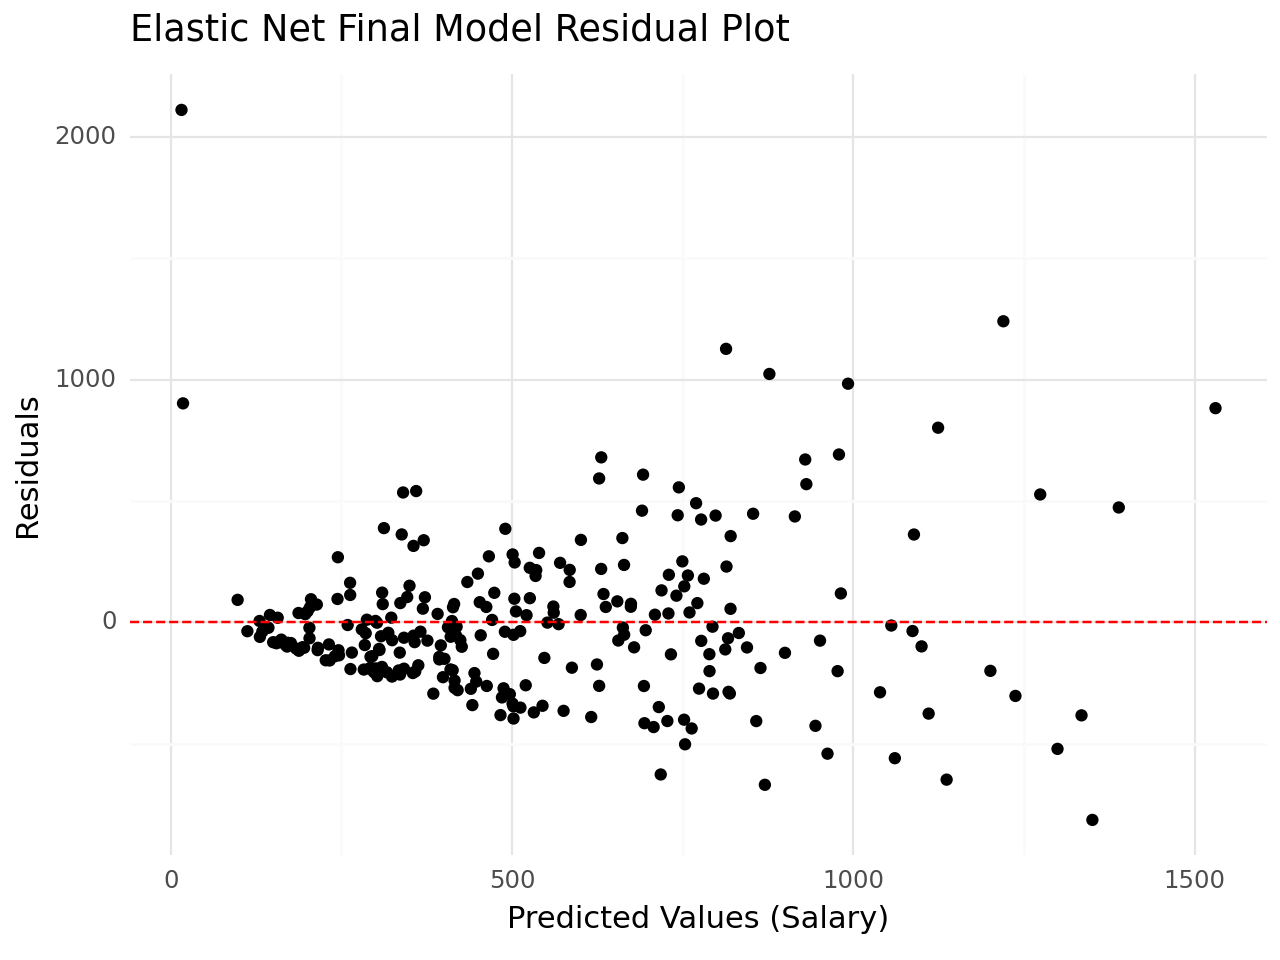

<Figure Size: (640 x 480)>

In [57]:
# Calculate residuals
residuals = y - enet_best_pred

# Create a DataFrame with residuals
residual_data = pd.DataFrame({'Predicted Values (Salary)': enet_best_pred, 'Residuals': residuals})

# Create the residual plot using ggplot
(ggplot(residual_data, aes(x="Predicted Values (Salary)", y="Residuals"))
+ geom_point()
+ geom_hline(yintercept=0, linetype="dashed", color="red")
+ labs(x="Predicted Values (Salary)", y="Residuals")
+ theme_minimal()
+ ggtitle("Elastic Net Final Model Residual Plot")
)

### Conclusion

After fitting Ordinary least squares, Ridge Regression, LASSO regression, and Elastic Net for all the variables, I found which Model performed the best among those. Elastic Net was the best from those and so I proceeded with Fidning the most meaningful variables from that Model. The method was finding the ones that affected the dependent variable the most. Once I had those most meaningful variables I was also interested in finding the most meaningful categorical variable. I proceed to find the best model in terms of MSE which included or didn't include the categorical variable and its interaction with the best five numerical variables. Finally Elastic Net was the best model and after hypertuning the parameters I found the best parameters to put in the model for the best predictions. In the end, above is a plot of the residuals against the predicted values which allows us to see how well this model can be expected to perform.